<a href="https://colab.research.google.com/github/PeraHive/project-redspot/blob/main/Simulations/Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Redspot

> By PeraHive

A robust IR vision-based localization framework for autonomous robotics

# Basic Implementation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
MAP_SIZE = 3000
BEACON_MAP = {
    "B0": np.array([500.0, 500.0]),
    "B1": np.array([2500.0, 500.0]),
    "B2": np.array([1500.0, 1500.0]),
    "B3": np.array([500.0, 2500.0]),
    "B4": np.array([2500.0, 2500.0])
}

In [3]:
IMG_W, IMG_H = 480, 360
FOCAL_LENGTH = 400
ALTITUDE = 100

In [4]:
class ParticleFilter:
    def __init__(self, num_particles, map_size):
        self.num_particles = num_particles
        # Initialize particles randomly across the map
        self.particles = np.random.rand(num_particles, 2) * map_size
        self.weights = np.ones(num_particles) / num_particles

    def predict(self, move_step, std_dev=10):
        """Move particles based on drone movement + random noise"""
        self.particles += move_step + np.random.normal(0, std_dev, (self.num_particles, 2))
        # Keep particles within map bounds
        self.particles = np.clip(self.particles, 0, MAP_SIZE)

    def update(self, observed_blobs):
        """Re-weight particles based on how well they 'see' the beacons"""
        if len(observed_blobs) == 0:
            return # No info to update weights

        for i, p_pos in enumerate(self.particles):
            particle_likelihood = 0

            # For each particle, calculate where it WOULD see beacons
            for b_id, b_pos in BEACON_MAP.items():
                dx, dy = b_pos - p_pos
                px = (dx * FOCAL_LENGTH / ALTITUDE) + (IMG_W / 2)
                py = (dy * FOCAL_LENGTH / ALTITUDE) + (IMG_H / 2)

                # Check if this beacon should be in FOV for this particle
                if 0 <= px < IMG_W and 0 <= py < IMG_H:
                    # Compare to actual detected blobs in IR Matrix
                    for blob in observed_blobs:
                        dist = np.linalg.norm(np.array([px, py]) - blob)
                        # Gaussian likelihood: closer the better
                        particle_likelihood += np.exp(-dist**2 / (2 * 20**2))

            self.weights[i] = particle_likelihood + 1e-300 # Avoid zero

        self.weights /= np.sum(self.weights)

    def resample(self):
        """Focus particles in high-probability areas"""
        indices = np.random.choice(np.arange(self.num_particles),
                                   size=self.num_particles,
                                   p=self.weights)
        self.particles = self.particles[indices]
        self.weights = np.ones(self.num_particles) / self.num_particles

    def estimate(self):
        """Return the average position of all particles"""
        return np.average(self.particles, weights=self.weights, axis=0)

In [5]:
def get_flight_path(steps):
    """Generates a parametric flight path (Lissajous Curve)"""
    t = np.linspace(0, 2 * np.pi, steps)
    x = 1500 + 1000 * np.cos(t)
    y = 1500 + 1000 * np.sin(2 * t)
    return np.stack((x, y), axis=-1)

In [6]:
def capture_blobs(current_pos):
    """Simulates IR sensor and returns centroid coordinates of visible beacons"""
    blobs = []
    for b_pos in BEACON_MAP.values():
        dx, dy = b_pos - current_pos
        px = (dx * FOCAL_LENGTH / ALTITUDE) + (IMG_W / 2)
        py = (dy * FOCAL_LENGTH / ALTITUDE) + (IMG_H / 2)
        if 0 <= px < IMG_W and 0 <= py < IMG_H:
            # Add a bit of sensor noise to the detection
            blobs.append(np.array([px, py]) + np.random.normal(0, 2, 2))
    return blobs

In [7]:
num_steps = 100
real_path = get_flight_path(num_steps)
estimated_path = []

In [8]:
pf = ParticleFilter(num_particles=500, map_size=MAP_SIZE)

In [9]:
for i in range(num_steps):
    actual_pos = real_path[i]

    # Calculate movement since last step
    move_step = actual_pos - real_path[i-1] if i > 0 else np.array([0, 0])

    # 1. Predict
    pf.predict(move_step)

    # 2. Observe (Sensor Capture)
    blobs = capture_blobs(actual_pos)

    # 3. Update & Resample
    pf.update(blobs)
    pf.resample()

    # 4. Save Estimate
    estimated_path.append(pf.estimate())

estimated_path = np.array(estimated_path)

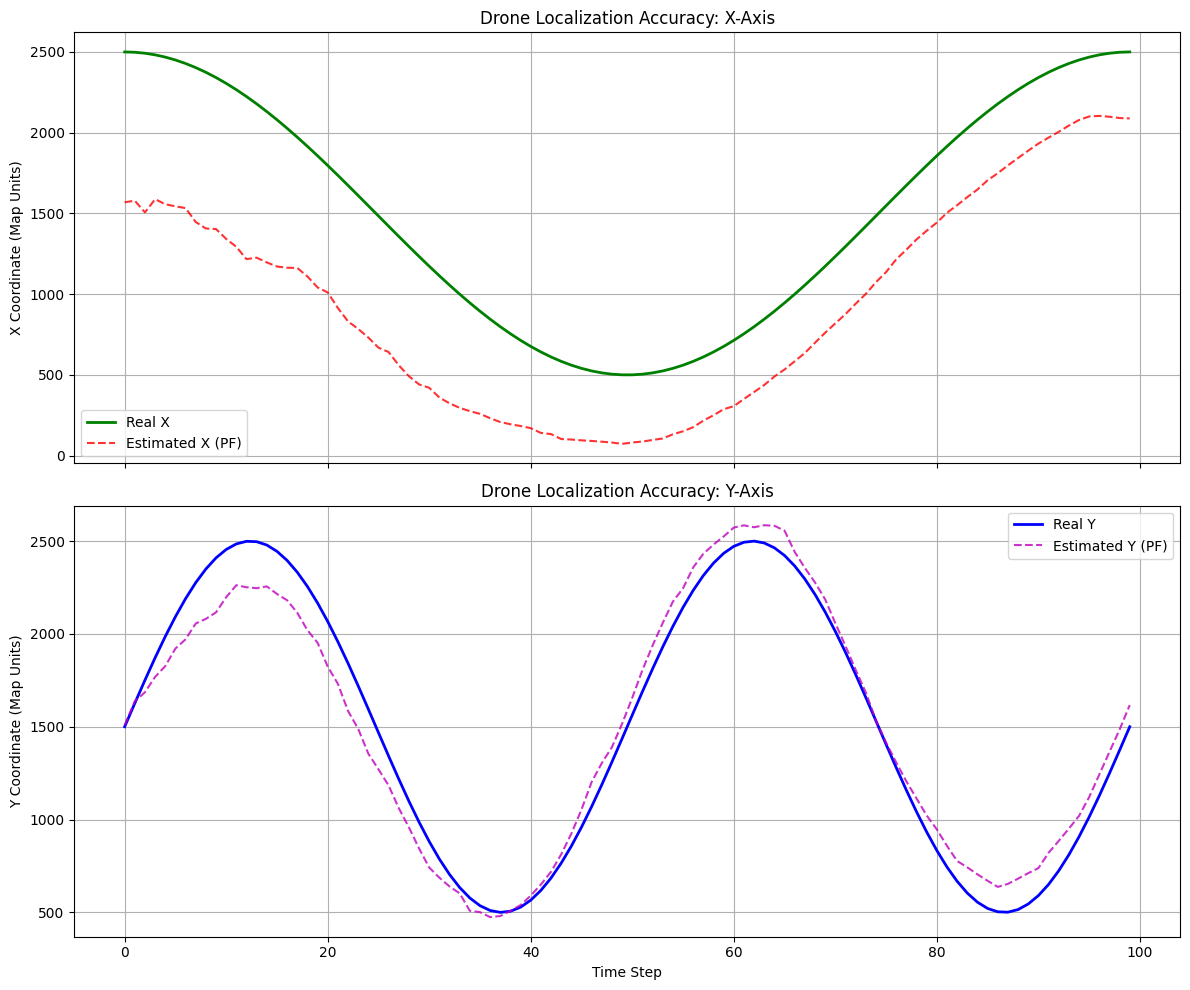

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# X-Coordinate Comparison
ax1.plot(real_path[:, 0], 'g-', label='Real X', linewidth=2)
ax1.plot(estimated_path[:, 0], 'r--', label='Estimated X (PF)', alpha=0.8)
ax1.set_ylabel("X Coordinate (Map Units)")
ax1.set_title("Drone Localization Accuracy: X-Axis")
ax1.legend()
ax1.grid(True)

# Y-Coordinate Comparison
ax2.plot(real_path[:, 1], 'b-', label='Real Y', linewidth=2)
ax2.plot(estimated_path[:, 1], 'm--', label='Estimated Y (PF)', alpha=0.8)
ax2.set_ylabel("Y Coordinate (Map Units)")
ax2.set_xlabel("Time Step")
ax2.set_title("Drone Localization Accuracy: Y-Axis")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()